<a href="https://colab.research.google.com/github/Mozzer2310/text-mining-cwk/blob/wills-kitchen/bi_gru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Mining

## Dataset

We first need to download the DialogRE dataset from HuggingFace:

In [1]:
!pip install datasets -q

import datasets

dialog_re = datasets.load_dataset(
    'dataset-org/dialog_re',
    download_mode='force_redownload',
    trust_remote_code=True,
)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.7 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

dialog_re.py:   0%|          | 0.00/4.83k [00:00<?, ?B/s]

dialog_re.py:   0%|          | 0.00/4.83k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.45k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1073 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/357 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/358 [00:00<?, ? examples/s]

We then extract the relevant information and transform each split into a PyTorch dataset:

In [2]:
import collections
import torch

from torch.utils import data

Example = collections.namedtuple(
    'Example', ['dialog', 'subject', 'object', 'relations']
)

class DialogREDataset(data.Dataset):
    def __init__(self, dialog_re_dataset):
        super().__init__()

        self.data = []
        for example in dialog_re_dataset:
            dialog, relation_data = example['dialog'], example['relation_data']

            # Join the lines of the dialog together
            dialog = '\n'.join(dialog)

            # Extract relation data
            for sbj, obj, rids in zip(
                relation_data['x'],
                relation_data['y'],
                relation_data['rid']
            ):
                # Construct each row of data
                row = Example(
                    dialog,
                    sbj,
                    obj,
                    torch.tensor(
                        [1 if i in rids else 0 for i in range(1, 38)]
                    ),
                )

                # Add row of data
                self.data.append(row)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Set up PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

# Separate splits
train_split = dialog_re['train']
validation_split = dialog_re['validation']
test_split = dialog_re['test']

# Transform into PyTorch datasets
train_dataset = DialogREDataset(train_split)
validation_dataset = DialogREDataset(validation_split)
test_dataset = DialogREDataset(test_split)

# Apply DataLoader
train_data_loader = data.DataLoader(
    train_dataset,
    batch_size=None,
    shuffle=True,
    generator=torch.Generator(device=device)
)
validation_data_loader = data.DataLoader(validation_dataset, batch_size=None)
test_data_loader = data.DataLoader(test_dataset, batch_size=None)


## GloVE Vectors

As in the original paper, we download the GloVE word embeddings:

In [3]:
import spacy

spacy.cli.download('en_core_web_lg')
nlp = spacy.load('en_core_web_lg')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Model

We can then define our model, which consists of a BiGRU and a single layer FNN.

In [4]:
import torch
import numpy as np

from spacy import matcher
from torch import nn

class RelationExtractor(nn.Module):
    def __init__(self, hidden_dim, n_relation_types, nlp):
        super().__init__()

        token_vector_dim = nlp.vocab.vectors.shape[1]

        self.nlp = nlp

        # NOTE: the resulting contextual vector dim is 2 * hidden_dim!
        self.encoder = nn.GRU(
            token_vector_dim,
            hidden_dim,
            bidirectional=True,
        )

        self.classifier = nn.Linear(
            4 * hidden_dim,
            n_relation_types,
        )

    def forward(self, doc, sbj, obj):
        # Tokenize the document, subject and object
        doc = self.nlp.make_doc(doc)
        sbj = self.nlp.make_doc(sbj)
        obj = self.nlp.make_doc(obj)

        # Calculate the contextual word vectors
        doc_vectors = [token.vector for token in doc]
        doc_vectors = np.vstack(doc_vectors)
        doc_vectors = torch.from_numpy(doc_vectors).to(device)
        embedded_vectors, _ = self.encoder(doc_vectors)

        # Calculate the subject and object vectors
        entity_matcher = matcher.PhraseMatcher(nlp.vocab, 'LOWER')
        entity_matcher.add('SBJ', [sbj])
        entity_matcher.add('OBJ', [obj])

        sbj_vectors = []
        obj_vectors = []
        for match_id, start, end in entity_matcher(doc):
            entity_vector = embedded_vectors[start:end].mean(dim=0)
            if nlp.vocab.strings[match_id] == 'SBJ':
                sbj_vectors.append(entity_vector)
            else:
                obj_vectors.append(entity_vector)

        # If the entity is not mentioned in the text, set the vector to zero
        if sbj_vectors:
            sbj_vector = torch.stack(sbj_vectors).mean(dim=0)
        else:
            sbj_vector = torch.zeros(embedded_vectors.shape[1])

        if obj_vectors:
            obj_vector = torch.stack(obj_vectors).mean(dim=0)
        else:
            obj_vector = torch.zeros_like(sbj_vector)

        # Calculate the logits for each relation
        return self.classifier(torch.cat([sbj_vector, obj_vector]))

## Hyperparameter selection

First, we define some training and evaluation code:

In [32]:
from sklearn import metrics
from torch import optim
from torch.nn import functional as F

def train(model, optimizer, data_loader):
    for dialog, sbj, obj, relations in data_loader:
        optimizer.zero_grad()
        predictions = model(dialog, sbj, obj)
        relations = relations.float()
        loss = F.binary_cross_entropy_with_logits(predictions, relations)
        loss.backward()
        optimizer.step()

def evaluate(model, data_loader, threshold=0.5, metric=metrics.f1_score):
    all_predictions = []
    all_relations = []
    with torch.no_grad():
        for dialog, sbj, obj, relations in data_loader:
            predictions = torch.sigmoid(model(dialog, sbj, obj))

            # Apply threshold
            predictions = (predictions > threshold).long().cpu().numpy()
            all_predictions.append(predictions)

            all_relations.append(relations.cpu().numpy())
    return metric(all_relations, all_predictions, average='samples')

To select the a value for the `hidden_dim` hyperparameter, we train four models with the following `hidden_dim` values: 5, 15, 75, 150

In [ ]:
import pandas as pd

from torch import optim
from torch.nn import functional as F

Result = collections.namedtuple(
    'Result',
    ['hidden_dim', 'epoch', 'f1_score']
)

hidden_dims = [5, 15, 75, 150]
epochs = 30
results = []

for hidden_dim in hidden_dims:
    print(f'hidden_dim: {hidden_dim}, context_dim: {2 * hidden_dim}')
    model = RelationExtractor(hidden_dim, 37, nlp)
    optimizer = optim.AdamW(model.parameters())

    # Get initial evaluation
    f1_score = evaluate(model, validation_data_loader)
    result = Result(hidden_dim, 0, f1_score)
    results.append(result)
    print(result)

    # Get evaluations over training epochs
    for epoch in range(1, epochs + 1):
        train(model, optimizer, train_data_loader)
        f1_score = evaluate(model, validation_data_loader)
        result = Result(hidden_dim, epoch, f1_score)
        results.append(result)
        print(result)

results = pd.DataFrame(results)


hidden_dim: 5, context_dim: 10
Result(hidden_dim=5, epoch=0, f1_score=0.04720431777870912)
Result(hidden_dim=5, epoch=1, f1_score=0.16388018112156041)
Result(hidden_dim=5, epoch=2, f1_score=0.18996865203761754)
Result(hidden_dim=5, epoch=3, f1_score=0.2291884360849878)
Result(hidden_dim=5, epoch=4, f1_score=0.20794148380355276)
Result(hidden_dim=5, epoch=5, f1_score=0.23998606757227445)
Result(hidden_dim=5, epoch=6, f1_score=0.25391849529780564)
Result(hidden_dim=5, epoch=7, f1_score=0.27324973876698017)
Result(hidden_dim=5, epoch=8, f1_score=0.28416927899686517)
Result(hidden_dim=5, epoch=9, f1_score=0.2701846046673632)
Result(hidden_dim=5, epoch=10, f1_score=0.28996865203761757)
Result(hidden_dim=5, epoch=11, f1_score=0.3008533611981888)
Result(hidden_dim=5, epoch=12, f1_score=0.3069604086845466)
Result(hidden_dim=5, epoch=13, f1_score=0.296055381400209)
Result(hidden_dim=5, epoch=14, f1_score=0.3191832114245907)
Result(hidden_dim=5, epoch=15, f1_score=0.30498955067920586)
Result(hid

We can then plot the resulting F1 scores as follows:

<Axes: xlabel='epoch'>

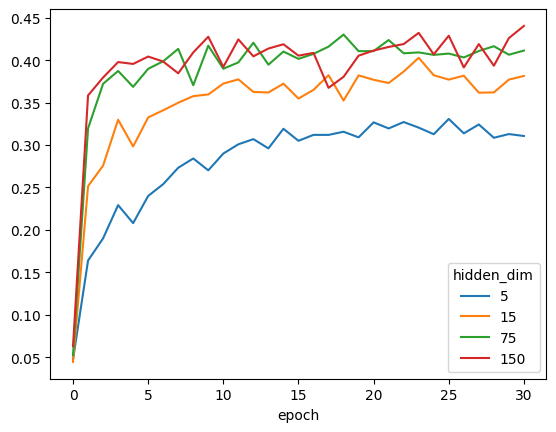

In [ ]:
pivoted = results.pivot(index='epoch', columns='hidden_dim', values='f1_score')
pivoted.plot()

We note that using a `hidden_dim` of 75 or 150 produces the best and comparable performance. Thus, we select a hidden_dim of 75 to reduce the possibility of overfitting.

## Final Model Training and Evaluation

We can train our final model by training on the training dataset and evaluating on both the validation and test datasets:

In [11]:
model = RelationExtractor(75, 37, nlp)
optimizer = optim.AdamW(model.parameters())

epochs = 30
test_results = []

# Get initial evaluation
validation_f1_score = evaluate(model, validation_data_loader)
test_f1_score = evaluate(model, test_data_loader)
test_result = {
    'epoch': 0,
    'valid_f1_score': validation_f1_score,
    'test_f1_score': test_f1_score
}
test_results.append(test_result)
print(test_result)

# Get evaluations over epochs
for epoch in range(1, epochs + 1):
    train(model, optimizer, train_data_loader)
    validation_f1_score = evaluate(model, validation_data_loader)
    test_f1_score = evaluate(model, test_data_loader)
    test_result = {
        'epoch': epoch,
        'valid_f1_score': validation_f1_score,
        'test_f1_score': test_f1_score
    }
    test_results.append(test_result)
    print(test_result)

{'epoch': 0, 'valid_f1_score': 0.06519306156819234, 'test_f1_score': 0.06499555373500075}
{'epoch': 1, 'valid_f1_score': 0.33019853709508884, 'test_f1_score': 0.349266022198353}
{'epoch': 2, 'valid_f1_score': 0.3182688958551027, 'test_f1_score': 0.3361012421162797}
{'epoch': 3, 'valid_f1_score': 0.35858585858585856, 'test_f1_score': 0.3941997851772288}
{'epoch': 4, 'valid_f1_score': 0.3750862860580729, 'test_f1_score': 0.39853204439670603}
{'epoch': 5, 'valid_f1_score': 0.4069139672587948, 'test_f1_score': 0.4214106695309703}
{'epoch': 6, 'valid_f1_score': 0.3905433646812957, 'test_f1_score': 0.42355201189787656}
{'epoch': 7, 'valid_f1_score': 0.3454371299198885, 'test_f1_score': 0.3483709273182957}
{'epoch': 8, 'valid_f1_score': 0.3877568791361895, 'test_f1_score': 0.4122986036519871}
{'epoch': 9, 'valid_f1_score': 0.4120515499825844, 'test_f1_score': 0.43048693161475116}
{'epoch': 10, 'valid_f1_score': 0.3985545106234762, 'test_f1_score': 0.4218582169709989}
{'epoch': 11, 'valid_f1_s

NameError: name 'pd' is not defined

We can plot the model's testing F1 scores.

<Axes: xlabel='epoch'>

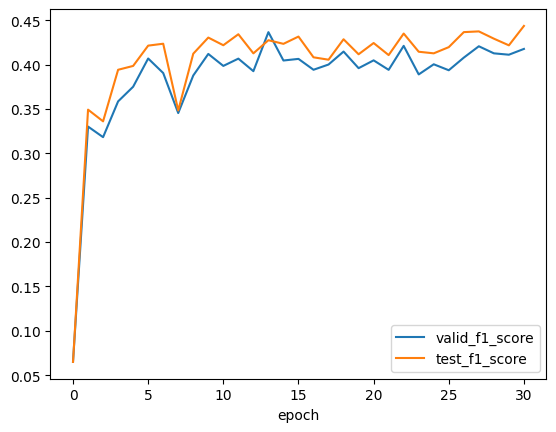

In [15]:
import pandas as pd

test_results = pd.DataFrame(test_results).set_index('epoch')
test_results.plot()

We can also print out its final testing F1 score:

In [16]:
test_results.iloc[-1]

,30
valid_f1_score,0.417707
test_f1_score,0.443617


Finally, we can save the model.

In [17]:
torch.save(model.state_dict(), 'bi_gru.pt')

## Loading the Model

We can load the trained model and re-evaluate as follows:

In [18]:
loaded_model = RelationExtractor(75, 37, nlp)
loaded_model.load_state_dict(torch.load('bi_gru.pt', weights_only=True))
loaded_model.eval()

f1_score = evaluate(loaded_model, train_data_loader)
print(f'Loaded model train score: {f1_score}')

f1_score = evaluate(loaded_model, validation_data_loader)
print(f'Loaded model validation score: {f1_score}')

f1_score = evaluate(loaded_model, test_data_loader)
print(f'Loaded model test score: {f1_score}')

Loaded model train score: 0.7455624637715683
Loaded model validation score: 0.4177072448624173
Loaded model test score: 0.4436171597825733


## Playground

Here, we set up some code to experiment with the trained model.

In [23]:
# Map relation id to relation string
relation_id_to_string = {}
for split in dialog_re.values():
    for example in split:
        relation_data = example['relation_data']
        for rids, rs in zip(relation_data['rid'], relation_data['r']):
            for rid, r in zip(rids, rs):
                relation_id_to_string[rid] = r

def get_relations(prediction):
    return [
        relation_id_to_string[i + 1] for i, p in enumerate(prediction) if p == 1
    ]

# Example
dialog = '''
Speaker 1: Call me later?
Speaker 2: Will do.
'''
logits = loaded_model(dialog, 'Speaker 1', 'Speaker 2')
relations_pred = torch.sigmoid(logits) > 0.3
get_relations(relations_pred)

['per:alumni']

Experimenting with the threshold value

In [73]:
experiment_results = []
for threshold in np.arange(0.1, 0.6, 0.1):
    validation_f1_score = evaluate(
        loaded_model,
        validation_data_loader,
        threshold
    )
    validation_recall_score = evaluate(
        loaded_model,
        validation_data_loader,
        threshold,
        metrics.recall_score
    )
    validation_precision_score = evaluate(
        loaded_model,
        validation_data_loader,
        threshold,
        metrics.precision_score
    )

    test_f1_score = evaluate(
        loaded_model,
        test_data_loader,
        threshold
    )
    test_recall_score = evaluate(
        loaded_model,
        test_data_loader,
        threshold,
        metrics.recall_score
    )
    test_precision_score = evaluate(
        loaded_model,
        test_data_loader,
        threshold,
        metrics.precision_score
    )

    result = {
        'Threshold': threshold,
        'Validation F1': validation_f1_score,
        'Validation Recall': validation_recall_score,
        'Validation Precision': validation_precision_score,

        'Test F1': test_f1_score,
        'Test Recall': test_recall_score,
        'Test Precision': test_precision_score,
    }
    experiment_results.append(result)
    print(result)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Threshold': 0.1, 'Validation F1': 0.4937994747215137, 'Validation Recall': 0.6388018112156042, 'Validation Precision': 0.43404126350834815, 'Test F1': 0.504138562911271, 'Test Recall': 0.6422305764411028, 'Test Precision': 0.4466332807901014}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Threshold': 0.2, 'Validation F1': 0.48417674279743245, 'Validation Recall': 0.5656565656565655, 'Validation Precision': 0.4482061999303378, 'Test F1': 0.4972695343801681, 'Test Recall': 0.5720551378446116, 'Test Precision': 0.46527505739137753}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Threshold': 0.30000000000000004, 'Validation F1': 0.4662486938349007, 'Validation Recall': 0.516805990943922, 'Validation Precision': 0.44447194265706064, 'Test F1': 0.47472763541506824, 'Test Recall': 0.5138739706408879, 'Test Precision': 0.45891170233275497}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Threshold': 0.4, 'Validation F1': 0.43845930570068503, 'Validation Recall': 0.4690003483106932, 'Validation Precision': 0.426014711004569, 'Test F1': 0.45730397422126745, 'Test Recall': 0.48254564983888293, 'Test Precision': 0.44786479184975425}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'Threshold': 0.5, 'Validation F1': 0.4177072448624173, 'Validation Recall': 0.43530128874956464, 'Validation Precision': 0.41173807035876, 'Test F1': 0.4436171597825733, 'Test Recall': 0.45757250268528465, 'Test Precision': 0.4395452918009309}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


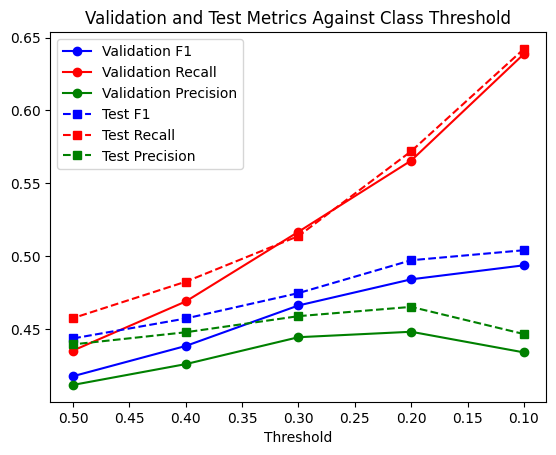

In [80]:
pd.DataFrame(experiment_results).set_index('Threshold').plot(
    title='Validation and Test Metrics Against Class Threshold',
    style=['bo-', 'ro-', 'go-', 'bs--', 'rs--', 'gs--']
).invert_xaxis()